In [1]:

import os
import keras
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Conv1D, Flatten, Input, MaxPooling2D, MaxPooling1D
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
#from google.colab import drive


In [2]:
#drive.mount('/content/drive')

In [2]:
train_path = "guitarchordsv3_archive/Training" # assuming this notebook is in the same directory as guitarchordsv3_archive
test_path = "guitarchordsv3_archive/Test"

sr = 16000  # sampling rate
n_mfcc = 80  # No. of mfcc features
N_CLASSES = 8  # No. of classes

In [3]:
def extract_mfcc(file, sr):
    audio, sr = librosa.load(file, sr=sr)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [4]:
def extract_spectrogram(file, sr, minlength):
    audio, sr = librosa.load(file, sr=sr)
    # Compute the spectrogram. n_mels is frequency step size, fmax is maximum frequency
    n_mels=128
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmax=8000)
    # Convert the spectrogram to decibel scale
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    #could use np.abs on the spectrogram
    
    # Need to pad or chop wav files. Only take first minlength of values, or pad with zeros until minlength is reached.
    spectrogram_db = spectrogram_db[:,:minlength] # python index slicing all rows with only minlength of columns
    d1, d2 = spectrogram_db.shape #extract the length of columns
    padding = np.zeros((n_mels, np.abs(minlength - d2))) # Create a 2D NumPy zeros array with rows=n_mels, for concat to work
    spectrogram_db_padded = np.concatenate((padding,spectrogram_db), axis=1) # concat columns axis only. Front padding first.
    # CNN expects single channel dimension (gray scale)
    spectrogram_db_dim = np.expand_dims(spectrogram_db_padded,axis=2)
    return spectrogram_db_dim

In [5]:
def get_data(folder_path):
    wav_paths = glob(f"{folder_path}/**", recursive=True)  # this list includes folder_path, all subfolder paths and all file paths inside subfolder paths.
    wav_paths = [x.replace(os.sep, '/') for x in wav_paths if '.wav' in x] # list of all audio file paths with '\\' replaced with '/'

    classes = sorted(os.listdir(folder_path))  # make a list of classes
    le = LabelEncoder()
    le.fit(classes)

    labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]  # remove audio file name and split using '/' to get label at the end
    labels = le.transform(labels)

    N = len(wav_paths)
    X = np.empty((N, n_mfcc), dtype=np.float32)  # create empty array to store audio samples later
    Y = np.empty((N, N_CLASSES), dtype=np.float32)

    for i, (wav_file, label) in enumerate(zip(wav_paths, labels)):
        X[i, :] = extract_mfcc(wav_file, sr)
        Y[i, :] = to_categorical(label, num_classes=N_CLASSES)
    print(classes)
    print(labels)

    return X, Y

In [6]:
def get_data_spectrograms(folder_path):
    wav_paths = glob(f"{folder_path}/**", recursive=True)  # this list includes folder_path, all subfolder paths and all file paths inside subfolder paths.
    wav_paths = [x.replace(os.sep, '/') for x in wav_paths if '.wav' in x] # list of all audio file paths with '\\' replaced with '/'

    classes = sorted(os.listdir(folder_path))  # make a list of classes/chords
    le = LabelEncoder()
    le.fit(classes) # give label encoder the list of chords to classify

    labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]  # remove audio file name and split using '/' to get label at the end
    labels = le.transform(labels)  # remaps chord names to integer values
    # labels array now has integer value (chord label) for each corresponding 1440 wav files
    
    # Need to pad or chop wav files. Only take first 48000 samples, or about first 3 seconds of wav audio
    N = len(wav_paths)  # length of wav_paths and labels should be exactly the same
    minHeight = 128 # height of input, also same as n_mels, which is frequency step size
    minLength = 200 # length of input
    X = np.empty((N, minHeight, minLength, 1), dtype=np.float32)  # create empty array to store audio samples later
    Y = np.empty((N, N_CLASSES), dtype=np.float32)

    for i, (wav_file, label) in enumerate(zip(wav_paths, labels)):
        X[i, :] = extract_spectrogram(wav_file, sr, minLength) #samplerate=16000
        Y[i, :] = to_categorical(label, num_classes=N_CLASSES) # one hot encoding. Converts a list of integers to binary flag with num_classes length.
    print(classes)
    print(labels)
    

    return X, Y

<h1>Define the three models</h1>

In [41]:
def model_dense():
    model = Sequential()
    model.add(Input(shape=(80,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(N_CLASSES, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

model1 = model_dense()
model1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 128)                 │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,528 (99.72 KB)

 Trainable params: 25,528 (99.72 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
def model_conv2d():
    model = Sequential()
    model.add(Input(shape=(128, 200, 1)))
    model.add(Conv2D(16, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="valid"))
    
    model.add(Conv2D(16, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 1), strides=(1, 1), padding="valid"))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()

    return model

model2 = model_conv2d()
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 198, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 125, 197, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 123, 195, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 123, 195, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 383760)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │      24,560,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,563,704 (93.70 MB)

 Trainable params: 24,563,704 (93.70 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
def model_conv1d():
    model = Sequential()
    model.add(Input(shape=(128*200, 1)))
    model.add(Conv1D(32, kernel_size=7, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()

    return model

model3 = model_conv1d()
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 25594, 32)           │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 25594, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 25592, 16)           │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 12796, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 204736)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │       6,551,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,553,656 (25.00 MB)

 Trainable params: 6,553,656 (25.00 MB)

 Non-trainable params: 0 (0.00 B)

 <h1>Train the ANN model using the dense architecture</h1>

In [42]:
X, Y = get_data(train_path)
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
[0 0 0 ... 7 7 7]
Shape of X: (1440, 80)
Shape of Y: (1440, 8)


In [43]:
epochs = 10
batch_size = 16
history1 = model1.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1425 - loss: 18.3911
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1238 - loss: 2.8385
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1213 - loss: 2.3779
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.1606 - loss: 2.2615
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.1356 - loss: 2.2032
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1602 - loss: 2.1422
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1429 - loss: 2.0892  
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1756 - loss: 2.0658
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2261 - loss: 2.0018  
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2560 - loss: 1.8626 


<h1>Train the 2-D CNN using 2-D architecture</h1>

In [49]:
x_train, y_train = get_data_spectrograms(train_path)
print(f"Shape of X: {x_train.shape}")
print(f"Shape of Y: {y_train.shape}")

['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
[0 0 0 ... 7 7 7]
Shape of X: (1440, 128, 200, 1)
Shape of Y: (1440, 8)


In [50]:
epochs = 3
batch_size = 16
history2 = model2.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.3204 - loss: 1180.0475
Epoch 2/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.9868 - loss: 0.0484
Epoch 3/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 1.0000 - loss: 5.4384e-04


<h1>Train the 1-D CNN using 1-D architecture</h1>

In [25]:
#x_train, y_train = get_data_spectrograms(train_path)
sample_size = x_train.shape[0] # number of samples in train set
y_axis = x_train.shape[1] # number of n_mels in train set
x_axis = x_train.shape[2] # minLength = 200 # length of input
channel_dimension = 1     # color channel is represented by 1 number

x_train_reshaped = x_train.reshape(sample_size, y_axis*x_axis, channel_dimension)

print(f"Shape of X: {x_train_reshaped.shape}")
print(f"Shape of Y: {x_train_reshaped.shape}")

Shape of X: (1440, 25600, 1)
Shape of Y: (1440, 25600, 1)


In [28]:
epochs = 10
batch_size = 16
history3 = model3.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.1236 - loss: 2.0794
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.1360 - loss: 2.0795
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.1280 - loss: 2.0793
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.1279 - loss: 2.0795
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.1100 - loss: 2.0797
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 0.1226 - loss: 2.0796
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.1320 - loss: 2.0794
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.1102 - loss: 2.0795
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.1356 - loss: 2.0796
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.1240 - loss: 2.0795


<h1>Display the plots for loss and accuracy for each of the models</h1>

In [44]:
history_dict1 = history1.history
loss_list1 = history_dict1['loss']
accuracy_list1 = history_dict1['accuracy']
print(f"Minimum Loss = {np.round(np.min(loss_list1), decimals=2)}")
print(f"Maximum Accuracy = {np.round(np.max(accuracy_list1)*100, decimals=2)}%")

Minimum Loss = 1.82
Maximum Accuracy = 26.88%


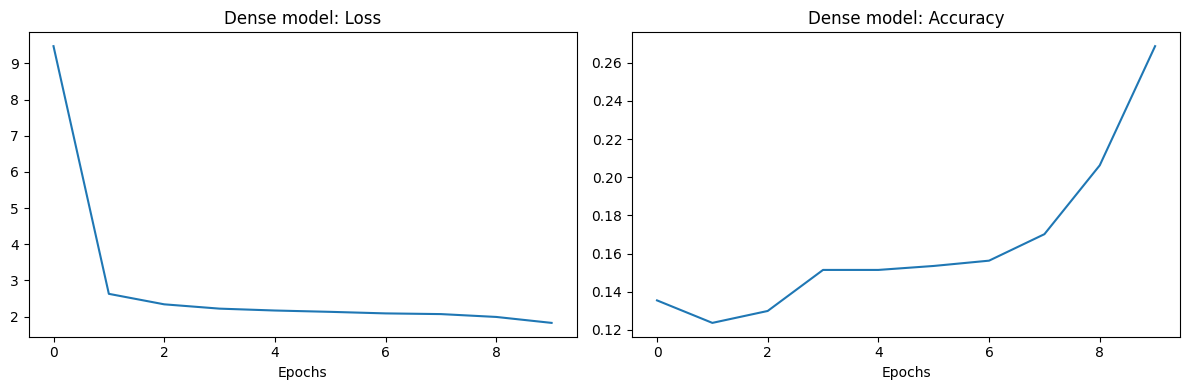

In [45]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(10), loss_list1) #epochs=10
plt.title("Dense model: Loss")
plt.xlabel("Epochs")
plt.subplot(1, 2, 2)
plt.plot(np.arange(10), accuracy_list1) #epochs=10
plt.title("Dense model: Accuracy")
plt.xlabel("Epochs")
plt.tight_layout()

In [17]:
history_dict2 = history2.history
loss_list2 = history_dict2['loss']
accuracy_list2 = history_dict2['accuracy']
print(f"Minimum Loss = {np.round(np.min(loss_list2), decimals=2)}")
print(f"Maximum Accuracy = {np.round(np.max(accuracy_list2)*100, decimals=2)}%")

Minimum Loss = 0.09
Maximum Accuracy = 97.99%


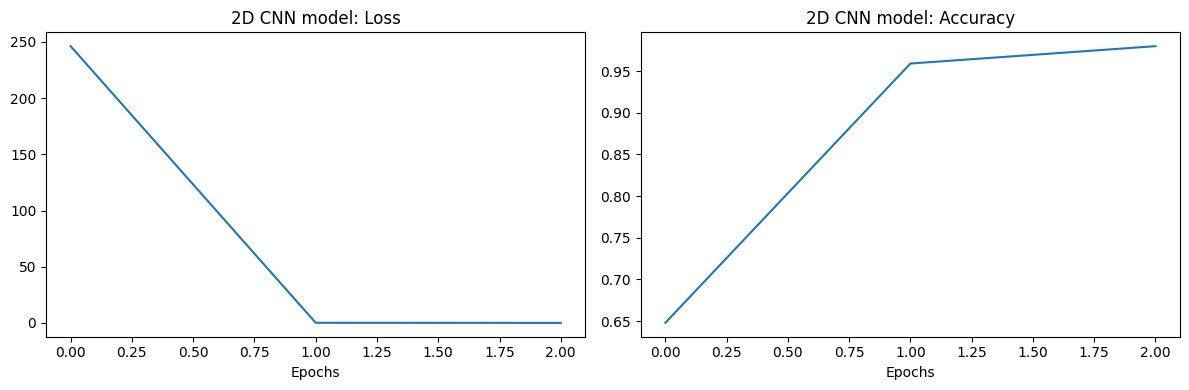

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(3), loss_list2) #epochs=3
plt.title("2D CNN model: Loss")
plt.xlabel("Epochs")
plt.subplot(1, 2, 2)
plt.plot(np.arange(3), accuracy_list2) #epochs=10
plt.title("2D CNN model: Accuracy")
plt.xlabel("Epochs")
plt.tight_layout()

In [39]:
history_dict3 = history3.history
loss_list3 = history_dict3['loss']
accuracy_list3 = history_dict3['accuracy']
print(f"Minimum Loss = {np.round(np.min(loss_list3), decimals=2)}")
print(f"Maximum Accuracy = {np.round(np.max(accuracy_list3)*100, decimals=2)}%")

Minimum Loss = 2.08
Maximum Accuracy = 12.5%


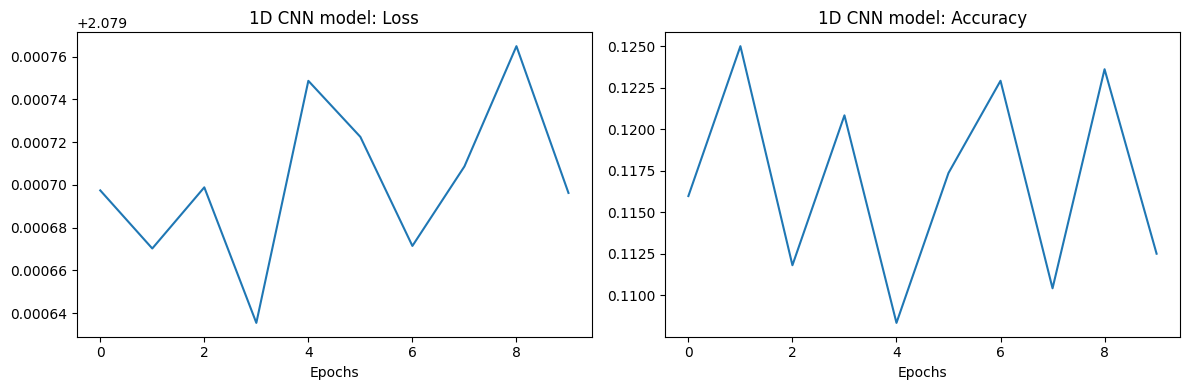

In [40]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), loss_list3)
plt.title("1D CNN model: Loss")
plt.xlabel("Epochs")
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), accuracy_list3)
plt.title("1D CNN model: Accuracy")
plt.xlabel("Epochs")
plt.tight_layout()

In [51]:
# Save the trained models
model1.save('models/ann.h5')
model2.save('models/cnn2d.h5')  # Change the path if needed
model3.save('models/cnn1d.h5')